In [6]:
train_dir = '/kaggle/input/new-dataset-her2/train'
test_dir = '/kaggle/input/new-dataset-her2/test'

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

# Set up early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='loss', save_best_only=True)

# Set up data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Set up test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Define image dimensions
IMG_HEIGHT, IMG_WIDTH = 224, 224

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load DenseNet121 base model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Found 8797 images belonging to 4 classes.
Found 2200 images belonging to 4 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
from IPython.display import FileLink

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)

# Load the best model
model.load_weights('best_model.keras')

# Save the final model after training
model.save('newdensenet121_50epochs.h5')  # Save the model

# Provide a link to download the saved model
FileLink('newdensenet121_50epochs.h5')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


275/275 ━━━━━━━━━━━━━━━━━━━━ 210s 662ms/step - accuracy: 0.6510 - loss: 6.4911
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 145s 513ms/step - accuracy: 0.8144 - loss: 3.1915
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 148s 525ms/step - accuracy: 0.8381 - loss: 2.0335
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 148s 526ms/step - accuracy: 0.8502 - loss: 1.5265
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 149s 530ms/step - accuracy: 0.8585 - loss: 1.2259
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 520ms/step - accuracy: 0.8525 - loss: 1.0471
Epoch 7/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 148s 526ms/step - accuracy: 0.8610 - loss: 0.9090
Epoch 8/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 146s 517ms/step - accuracy: 0.8754 - loss: 0.7913
Epoch 9/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 145s 515ms/step - accuracy: 0.8769 - loss: 0.7096
Epoch 10/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 146s 516ms/step - accuracy: 0.8670 - loss: 0.6625
Epoch 11/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 143s 508ms/step - accuracy: 0.8753 - loss: 0.6177
Epoch 12/50
275/275

/kaggle/working/newdensenet121_50epochs.h5

69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 482ms/step - accuracy: 0.8783 - loss: 0.3656
Test Loss (before fine-tuning): 0.30375394225120544
Test Accuracy (before fine-tuning): 0.8963636159896851
69/69 ━━━━━━━━━━━━━━━━━━━━ 28s 295ms/step


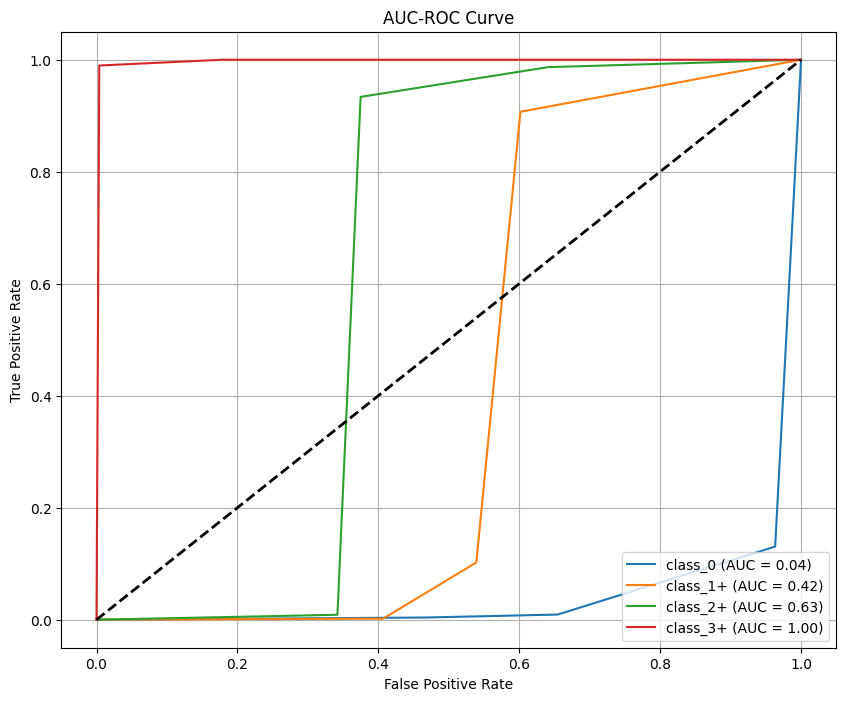


Classification Report:
              precision    recall  f1-score   support

     class_0       0.93      0.87      0.90       758
    class_1+       0.81      0.80      0.81       538
    class_2+       0.76      0.92      0.84       226
    class_3+       0.99      0.99      0.99       678

    accuracy                           0.90      2200
   macro avg       0.87      0.90      0.88      2200
weighted avg       0.90      0.90      0.90      2200



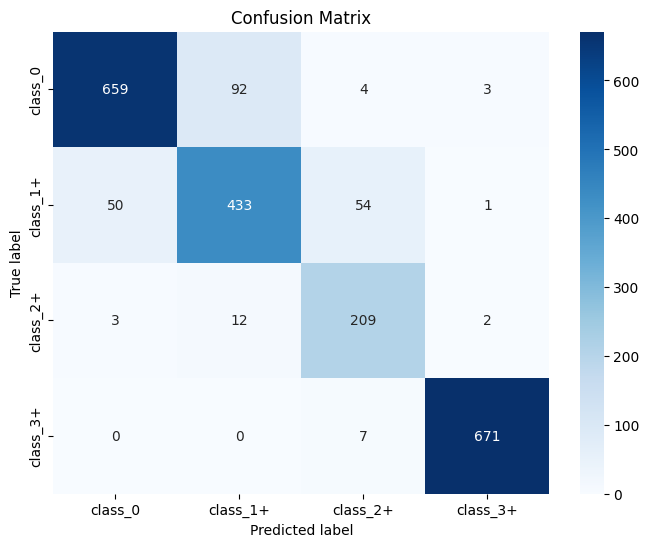

In [ ]:
import seaborn as sns

# Evaluate the model before fine-tuning
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss (before fine-tuning): {test_loss}")
print(f"Test Accuracy (before fine-tuning): {test_accuracy}")

# Predictions and evaluation before fine-tuning
test_predictions = model.predict(test_generator, verbose=1)
test_predictions = np.argmax(test_predictions, axis=-1)

# Compute AUC-ROC before fine-tuning
fpr, tpr, roc_auc = {}, {}, {}
true_labels = test_generator.classes
true_labels_one_hot = np.zeros((len(true_labels), len(test_generator.class_indices)))
for i, label in enumerate(true_labels):
    true_labels_one_hot[i, label] = 1

for i, class_name in enumerate(test_generator.class_indices.keys()):
    fpr[class_name], tpr[class_name], _ = roc_curve(true_labels_one_hot[:, i], test_predictions)
    roc_auc[class_name] = roc_auc_score(true_labels_one_hot[:, i], test_predictions)

# Plot AUC-ROC curve before fine-tuning
plt.figure(figsize=(10, 8))
for class_name in test_generator.class_indices.keys():
    plt.plot(fpr[class_name], tpr[class_name], label=f"{class_name} (AUC = {roc_auc[class_name]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Classification report before fine-tuning
print("\nClassification Report:")
print(classification_report(true_labels, test_predictions, target_names=test_generator.class_indices.keys()))

# Confusion matrix before fine-tuning
cm = confusion_matrix(true_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Heatmap for confusion matrix visualization before fine-tuning
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [1]:
from tensorflow.keras.models import load_model

# Load the uploaded model
model_path = "/kaggle/input/densenet/keras/default/1/newdensenet121_50epochs.h5"
model = load_model(model_path)

# Confirm the model architecture
print("Model loaded successfully!")

Model loaded successfully!


In [5]:
# Fine-tune the model by unfreezing the last 10 layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model after unfreezing layers
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model again after fine-tuning
history_finetune = model.fit(
    train_generator,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


275/275 ━━━━━━━━━━━━━━━━━━━━ 231s 717ms/step - accuracy: 0.3484 - loss: 8.1665
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 155s 547ms/step - accuracy: 0.6328 - loss: 7.1162
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 154s 547ms/step - accuracy: 0.7245 - loss: 6.4932
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 154s 545ms/step - accuracy: 0.7494 - loss: 6.0152
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 174s 617ms/step - accuracy: 0.7795 - loss: 5.5728
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 181s 639ms/step - accuracy: 0.8072 - loss: 5.1872
Epoch 7/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 179s 634ms/step - accuracy: 0.8187 - loss: 4.8540
Epoch 8/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 182s 646ms/step - accuracy: 0.8269 - loss: 4.5607
Epoch 9/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 180s 638ms/step - accuracy: 0.8327 - loss: 4.2996
Epoch 10/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 185s 654ms/step - accuracy: 0.8343 - loss: 4.0485
Epoch 11/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 184s 654ms/step - accuracy: 0.8464 - loss: 3.8106
Epoch 12/50
275/275

In [6]:
# Save the fine-tuned model
model.save('fine_tuned_densenet.h5')

In [7]:
from IPython.display import FileLink

# Create a download link
FileLink('/kaggle/working/fine_tuned_densenet.h5')

/kaggle/working/fine_tuned_densenet.h5

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


69/69 ━━━━━━━━━━━━━━━━━━━━ 47s 547ms/step - accuracy: 0.9271 - loss: 1.1570
Test Loss (after fine-tuning): 1.1486892700195312
Test Accuracy (after fine-tuning): 0.925000011920929
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 360ms/step


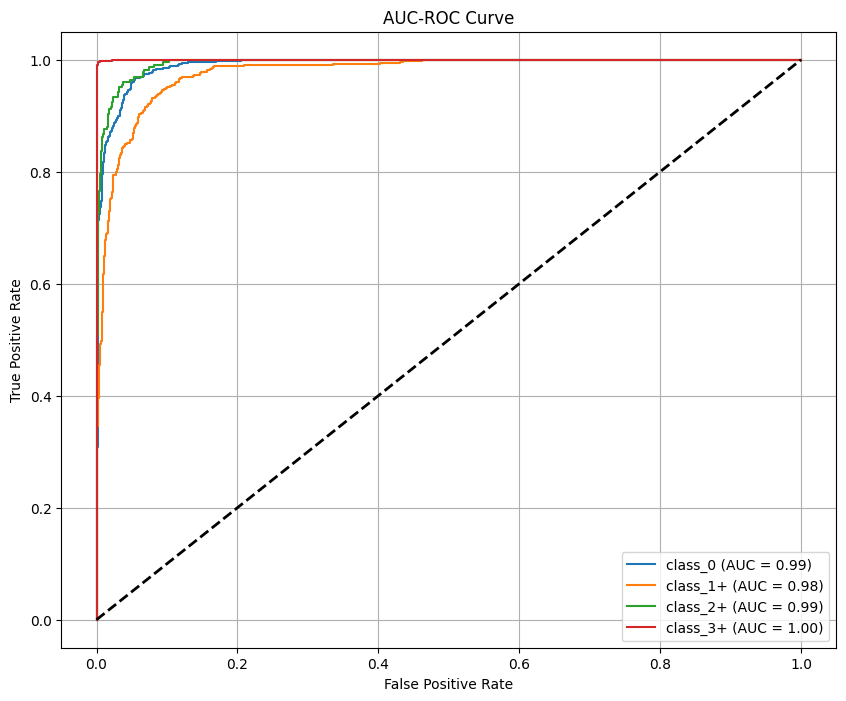


Classification Report:
              precision    recall  f1-score   support

     class_0       0.92      0.95      0.93       758
    class_1+       0.89      0.81      0.85       538
    class_2+       0.83      0.92      0.87       226
    class_3+       0.99      0.99      0.99       678

    accuracy                           0.93      2200
   macro avg       0.91      0.92      0.91      2200
weighted avg       0.93      0.93      0.92      2200



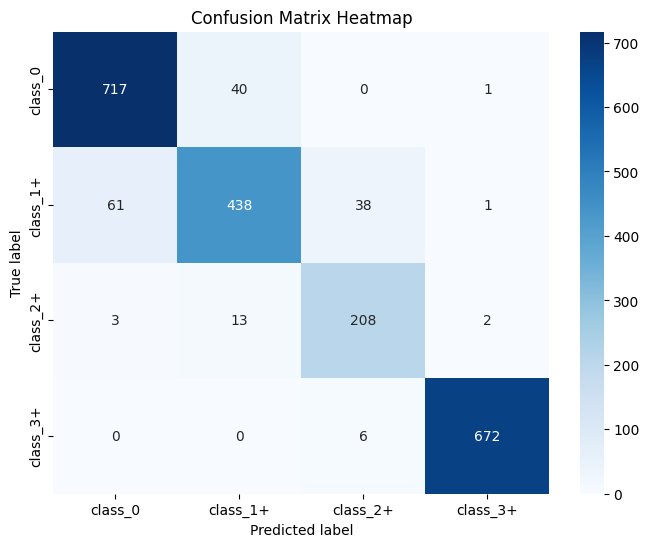

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

#* Evaluate the model after fine-tuning
test_loss_finetune, test_accuracy_finetune = model.evaluate(test_generator)
print(f"Test Loss (after fine-tuning): {test_loss_finetune}")
print(f"Test Accuracy (after fine-tuning): {test_accuracy_finetune}")

# Predictions and evaluation
test_probabilities = model.predict(test_generator, verbose=1)  # Get softmax probabilities
test_predictions = np.argmax(test_probabilities, axis=-1)  # Convert to class labels

# Get true labels
true_labels = test_generator.classes

# Compute AUC-ROC
fpr, tpr, roc_auc = {}, {}, {}
num_classes = len(test_generator.class_indices)

# Convert true labels to one-hot encoding
true_labels_one_hot = np.zeros((len(true_labels), num_classes))
for i, label in enumerate(true_labels):
    true_labels_one_hot[i, label] = 1

# Compute AUC-ROC for each class
for i, class_name in enumerate(test_generator.class_indices.keys()):
    fpr[class_name], tpr[class_name], _ = roc_curve(true_labels_one_hot[:, i], test_probabilities[:, i])  # Use probabilities
    roc_auc[class_name] = roc_auc_score(true_labels_one_hot[:, i], test_probabilities[:, i])

# Plot AUC-ROC curve
plt.figure(figsize=(10, 8))
for class_name in test_generator.class_indices.keys():
    plt.plot(fpr[class_name], tpr[class_name], label=f"{class_name} (AUC = {roc_auc[class_name]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, test_predictions, target_names=test_generator.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(true_labels, test_predictions)

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Gradient-Weighted Class Activation Mapping (GRAD-CAM)
Grad CAM consists in finding out which parts of the image have led a convolutional neural network to its final decision. This method consists of producing heat maps representing the activation classes on the images received as input. Each activation class is associated with a specific output class.

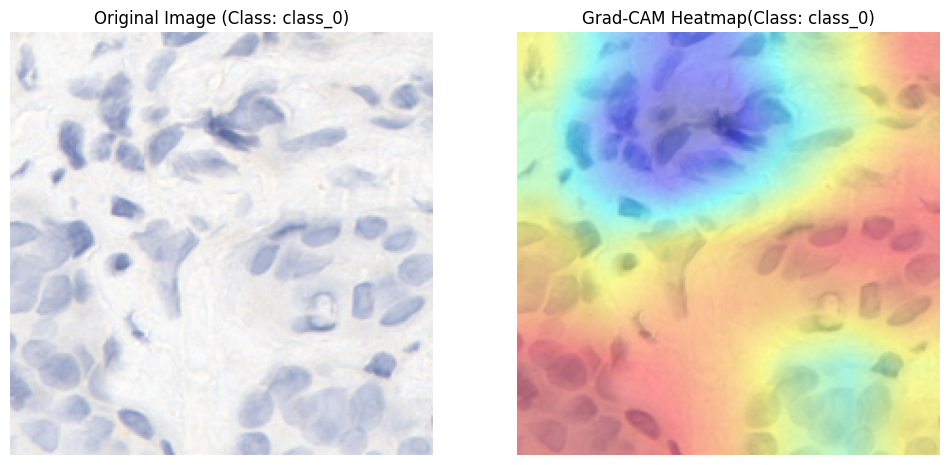

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import cv2
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
import seaborn as sns
import os

class_names = ['class_0', 'class_1+', 'class_2+', 'class_3+']

def get_grad_cam(model, img_array, class_index=None, last_conv_layer_name="conv5_block16_concat"):
    """
    Computes the Grad-CAM heatmap for the specified class index or predicted class.
    """
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_index is None:
            class_index = np.argmax(predictions[0])  # Default to predicted class
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Weighted activation map
    heatmap = np.dot(conv_outputs, pooled_grads.numpy())
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

    return heatmap, class_index

def display_grad_cam(image_path, model):
    """
    Loads an image, computes Grad-CAM, and visualizes the heatmap.
    """
    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")  # Ensure compatibility with PNG
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Extract class name from the image path
    class_name = os.path.basename(os.path.dirname(image_path))

    # Get Grad-CAM heatmap
    heatmap, predicted_class = get_grad_cam(model, img_array)

    plt.figure(figsize=(12, 6))

    # Show the original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Original Image (Class: {class_name})")
    plt.axis('off')

    # Resize and apply heatmap
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap on the original image
    img_rgb = np.array(img)
    superimposed_img = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM Heatmap(Class: {class_names[predicted_class]})")
    plt.axis('off')

    plt.show()

# Update with your image path
sample_image_path = "/kaggle/input/new-dataset-her2/test/class_0/her2-0-score_test_1167.png"  # Update with your correct PNG path
display_grad_cam(sample_image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


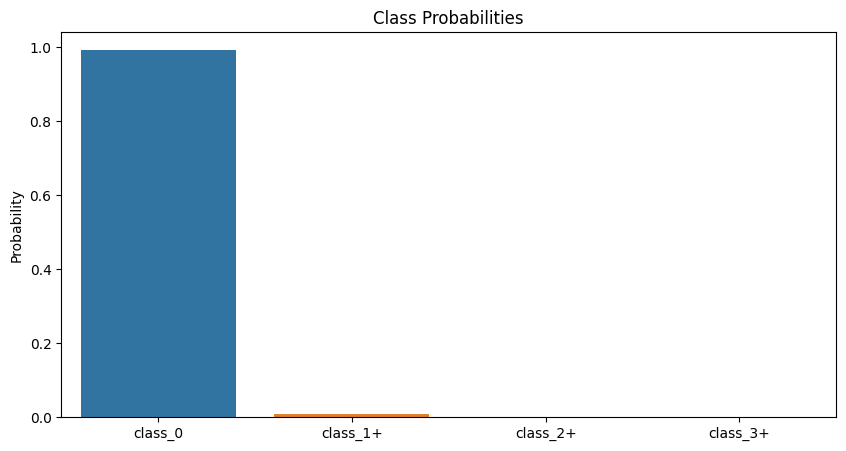

Class Probabilities:
class_0: 0.9908
class_1+: 0.0092
class_2+: 0.0000
class_3+: 0.0000
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 218ms/step

Confusion Matrix:


<Figure size 1000x600 with 0 Axes>

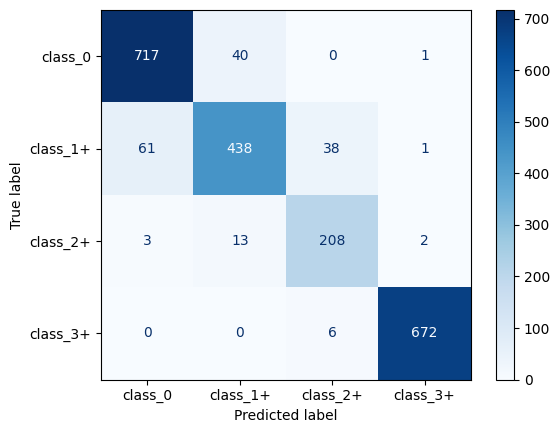


Classification Report:
              precision    recall  f1-score   support

     class_0       0.92      0.95      0.93       758
    class_1+       0.89      0.81      0.85       538
    class_2+       0.83      0.92      0.87       226
    class_3+       0.99      0.99      0.99       678

    accuracy                           0.93      2200
   macro avg       0.91      0.92      0.91      2200
weighted avg       0.93      0.93      0.92      2200

Macro-Averaged ROC AUC Score: 0.9904


In [12]:
# Define your custom class labels
custom_class_labels = ["class_0", "class_1+", "class_2+", "class_3+"]

def display_class_probabilities(img_path, model):
    """
    Display class probabilities for a single image.
    """
    # Load and preprocess the image
    img = Image.open(img_path).convert("RGB")  # Ensure compatibility with PNG
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Get predictions
    predictions = model.predict(img_array)
    class_probabilities = {custom_class_labels[i]: prob for i, prob in enumerate(predictions[0])}
    
    # Plot class probabilities
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(class_probabilities.keys()), y=list(class_probabilities.values()))
    plt.title("Class Probabilities")
    plt.ylabel("Probability")
    plt.show()

    # Print probabilities nicely
    print("Class Probabilities:")
    for class_name, prob in class_probabilities.items():
        print(f"{class_name}: {prob:.4f}")

display_class_probabilities(sample_image_path, model)

def evaluate_on_test_data(test_generator):
    """
    Evaluate the model on the test dataset and show confusion matrix and metrics.
    """
    # Get predictions and true labels
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # Print confusion matrix and classification report
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=custom_class_labels)
    
    plt.figure(figsize=(10, 6))  # Set figure size here
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=custom_class_labels))

    # Compute ROC AUC if it's meaningful for multi-class tasks
    roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), predictions, average="macro")
    print(f"Macro-Averaged ROC AUC Score: {roc_auc:.4f}")

# Evaluate on your test dataset
evaluate_on_test_data(test_generator)


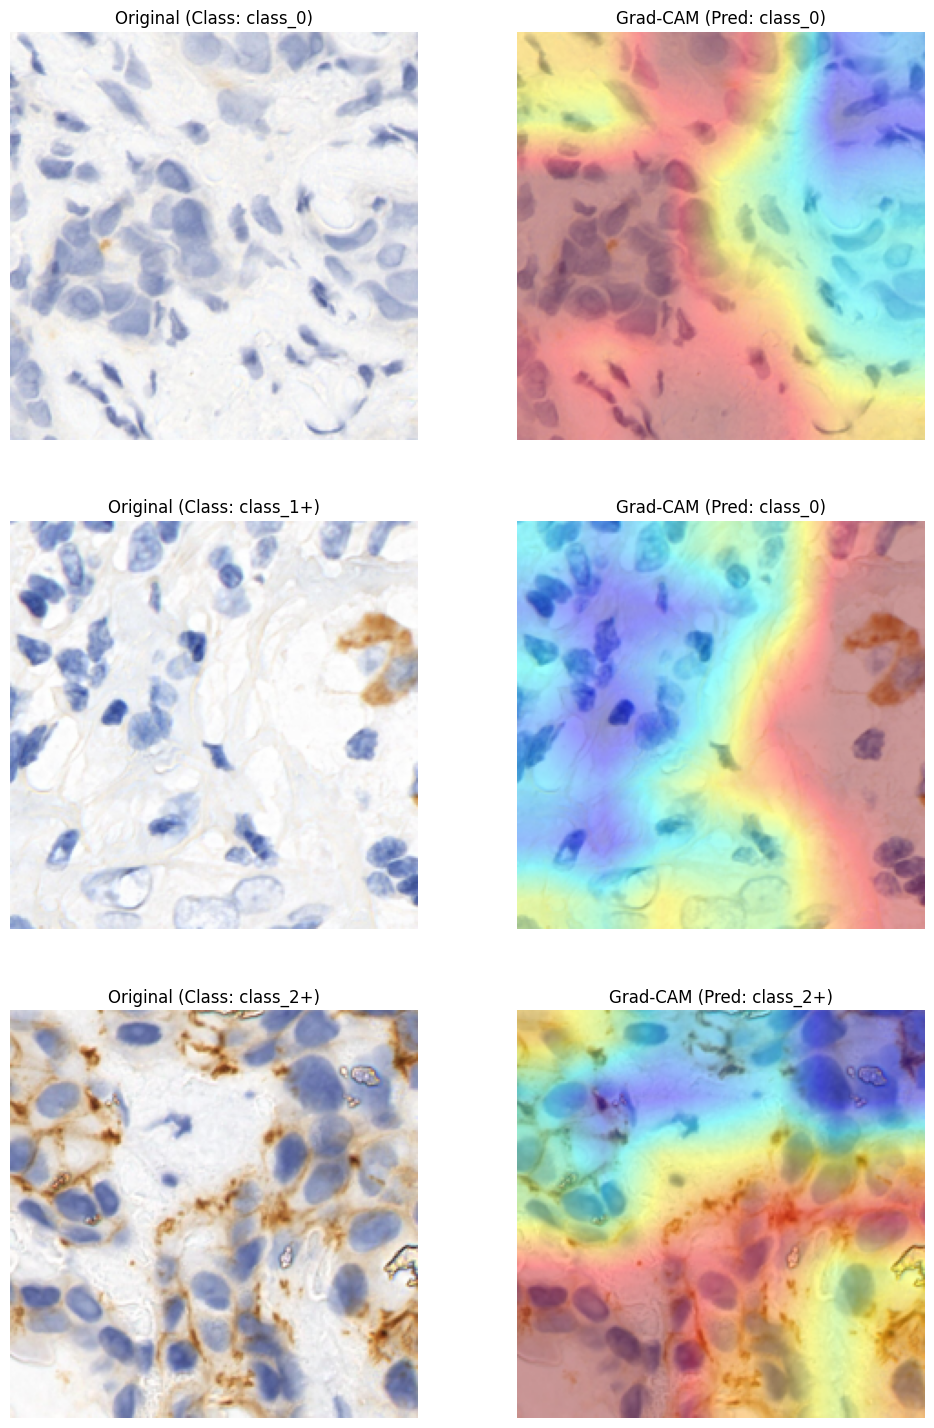

69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 218ms/step

Class-wise Precision, Recall, and F1-score:
class_0 - Precision: 0.9181, Recall: 0.9459, F1-Score: 0.9318
class_1+ - Precision: 0.8921, Recall: 0.8141, F1-Score: 0.8513
class_2+ - Precision: 0.8254, Recall: 0.9204, F1-Score: 0.8703
class_3+ - Precision: 0.9941, Recall: 0.9912, F1-Score: 0.9926
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 218ms/step


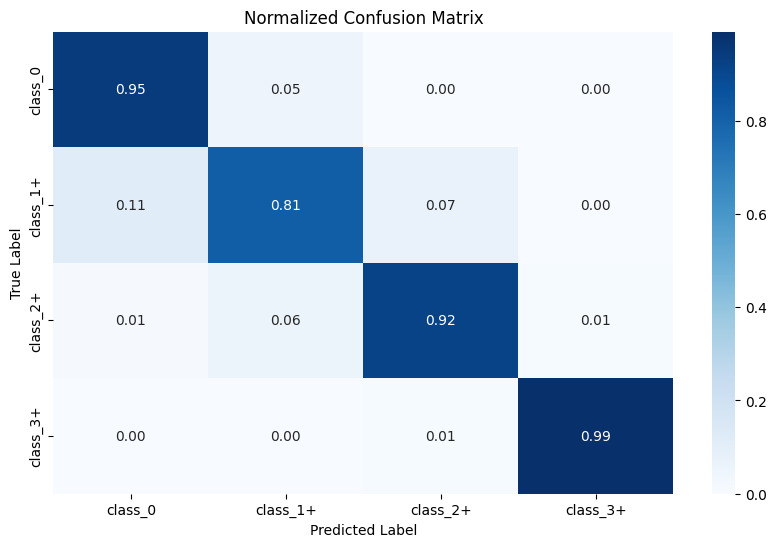

Saved Grad-CAM output: grad_cam_outputs/gradcam_her2-0-score_test_1172.png
Saved Grad-CAM output: grad_cam_outputs/gradcam_her2-0-score_train_3811.png
Saved Grad-CAM output: grad_cam_outputs/gradcam_her2-1+-score_train_2397.png
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 224ms/step

Per-Class Accuracy:
class_0: 0.9459
class_1+: 0.8141
class_2+: 0.9204
class_3+: 0.9912


In [14]:
# Additional Enhancements for HER2 Grad-CAM and Model Evaluation

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import cv2
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, precision_recall_fscore_support
import seaborn as sns
import os
import itertools

# Function to visualize multiple Grad-CAMs for different test images
def visualize_multiple_gradcams(image_paths, model):
    """
    Displays Grad-CAM visualizations for multiple images in a grid format.
    """
    num_images = len(image_paths)
    fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(12, 6 * num_images))

    for i, img_path in enumerate(image_paths):
        img = Image.open(img_path).convert("RGB")  # Ensure compatibility
        img = img.resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Extract class name from path
        class_name = os.path.basename(os.path.dirname(img_path))

        # Get Grad-CAM heatmap
        heatmap, predicted_class = get_grad_cam(model, img_array)

        # Resize and apply heatmap
        heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Superimpose heatmap on original image
        img_rgb = np.array(img)
        superimposed_img = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

        # Display original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original (Class: {class_name})")
        axes[i, 0].axis("off")

        # Display Grad-CAM
        axes[i, 1].imshow(superimposed_img)
        axes[i, 1].set_title(f"Grad-CAM (Pred: {class_names[predicted_class]})")
        axes[i, 1].axis("off")

    plt.show()

# Example usage: Visualize multiple Grad-CAM images
sample_image_paths = [
    "/kaggle/input/new-dataset-her2/test/class_0/her2-0-score_test_1172.png",
    "/kaggle/input/new-dataset-her2/test/class_1+/her2-0-score_train_3811.png",
    "/kaggle/input/new-dataset-her2/test/class_2+/her2-1+-score_train_2397.png",
]
visualize_multiple_gradcams(sample_image_paths, model)

# Compute precision, recall, F1-score for each class
def compute_classwise_metrics(y_true, y_pred):
    """
    Computes precision, recall, and F1-score per class.
    """
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    metrics_df = {
        "Class": custom_class_labels,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
    }

    print("\nClass-wise Precision, Recall, and F1-score:")
    for i in range(len(custom_class_labels)):
        print(f"{custom_class_labels[i]} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-Score: {f1[i]:.4f}")

    return metrics_df

# Display model performance per class
metrics_df = compute_classwise_metrics(test_generator.classes, np.argmax(model.predict(test_generator), axis=1))

# Generate normalized confusion matrix
def plot_normalized_confusion_matrix(y_true, y_pred, labels):
    """
    Plots a normalized confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_normalized_confusion_matrix(test_generator.classes, np.argmax(model.predict(test_generator), axis=1), custom_class_labels)

# Save Grad-CAM heatmap outputs for later analysis
def save_grad_cam_output(image_path, model, output_dir="grad_cam_outputs"):
    """
    Computes Grad-CAM heatmap and saves the result.
    """
    os.makedirs(output_dir, exist_ok=True)
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    heatmap, predicted_class = get_grad_cam(model, img_array)

    # Resize heatmap
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose on original image
    img_rgb = np.array(img)
    superimposed_img = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

    # Save output image
    output_path = os.path.join(output_dir, f"gradcam_{os.path.basename(image_path)}")
    cv2.imwrite(output_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))
    print(f"Saved Grad-CAM output: {output_path}")

# Save sample Grad-CAM heatmaps
for img_path in sample_image_paths:
    save_grad_cam_output(img_path, model)

# Compute per-class accuracy
def compute_per_class_accuracy(y_true, y_pred, labels):
    """
    Computes accuracy for each class.
    """
    cm = confusion_matrix(y_true, y_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    
    print("\nPer-Class Accuracy:")
    for i, label in enumerate(labels):
        print(f"{label}: {per_class_acc[i]:.4f}")

    return per_class_acc

per_class_acc = compute_per_class_accuracy(test_generator.classes, np.argmax(model.predict(test_generator), axis=1), custom_class_labels)


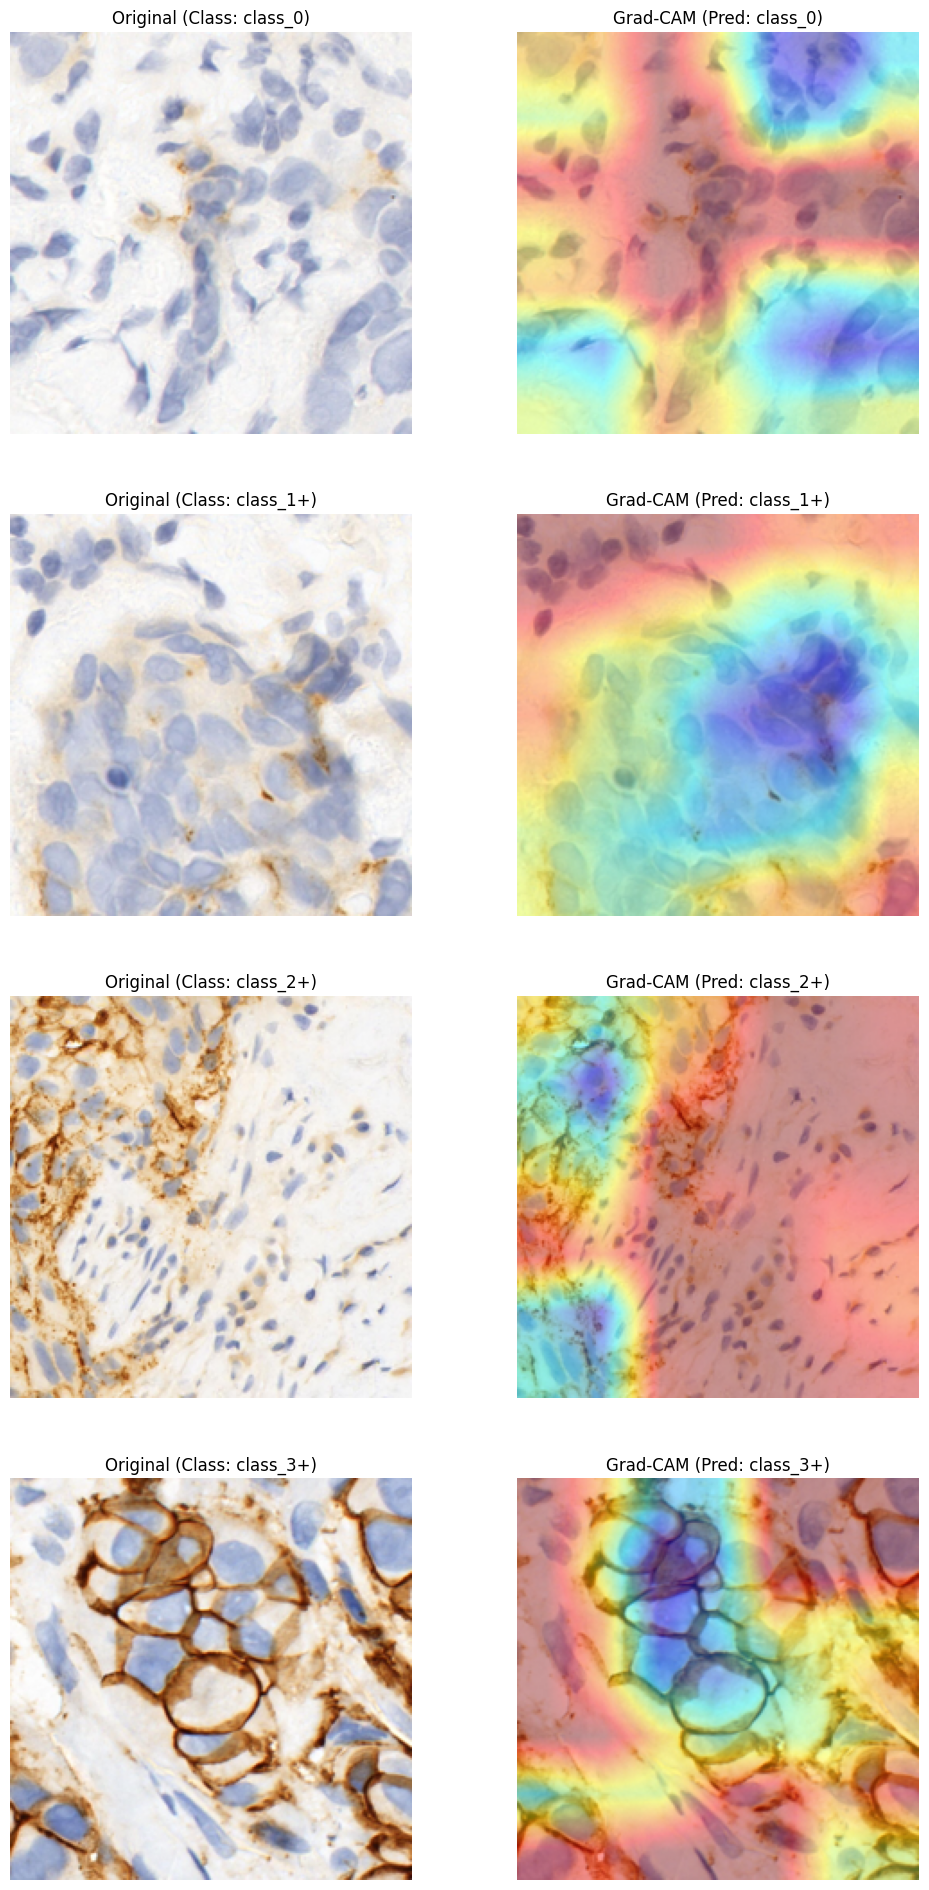

69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 253ms/step

Class-wise Precision, Recall, and F1-score:
class_0 - Precision: 0.9181, Recall: 0.9459, F1-Score: 0.9318
class_1+ - Precision: 0.8921, Recall: 0.8141, F1-Score: 0.8513
class_2+ - Precision: 0.8254, Recall: 0.9204, F1-Score: 0.8703
class_3+ - Precision: 0.9941, Recall: 0.9912, F1-Score: 0.9926


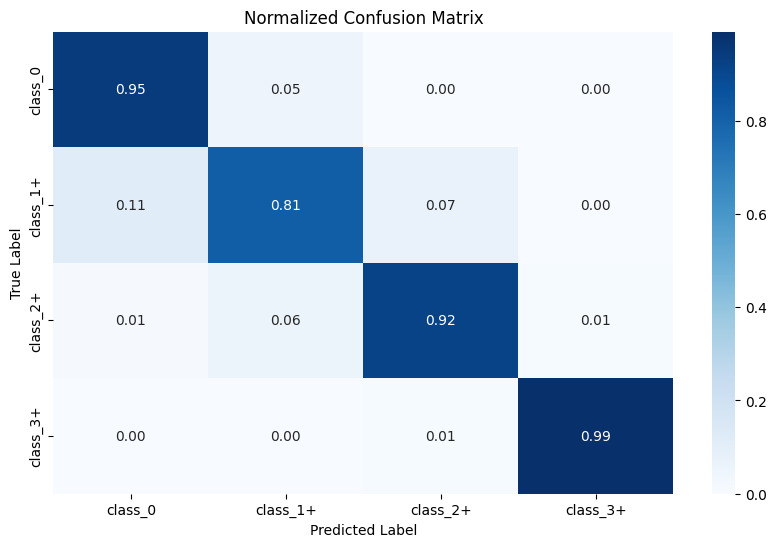

Saved Grad-CAM output: grad_cam_outputs/gradcam_her2-0-score_test_1180.png
Saved Grad-CAM output: grad_cam_outputs/gradcam_her2-0-score_test_1299.png
Saved Grad-CAM output: grad_cam_outputs/gradcam_her2-1+-score_test_18.png
Saved Grad-CAM output: grad_cam_outputs/gradcam_her2-2+-score_test_178.png

Per-Class Accuracy:
class_0: 0.9459
class_1+: 0.8141
class_2+: 0.9204
class_3+: 0.9912


In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import cv2
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import os

# Define class labels, including 'class_3+'
custom_class_labels = ["class_0", "class_1+", "class_2+", "class_3+"]

# Function to compute Grad-CAM heatmap
def get_grad_cam(model, img_array, last_conv_layer_name="conv5_block16_concat"):
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predicted_class = np.argmax(predictions[0])
        class_channel = predictions[:, predicted_class]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)[0]
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy(), predicted_class

# Function to visualize multiple Grad-CAMs for different test images
def visualize_multiple_gradcams(image_paths, model):
    num_images = len(image_paths)
    fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(12, 6 * num_images))

    for i, img_path in enumerate(image_paths):
        img = Image.open(img_path).convert("RGB")  # Ensure compatibility
        img = img.resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Extract class name from path
        class_name = os.path.basename(os.path.dirname(img_path))

        # Get Grad-CAM heatmap
        heatmap, predicted_class = get_grad_cam(model, img_array)

        # Resize and apply heatmap
        heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Superimpose heatmap on original image
        img_rgb = np.array(img)
        superimposed_img = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

        # Display original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original (Class: {class_name})")
        axes[i, 0].axis("off")

        # Display Grad-CAM
        axes[i, 1].imshow(superimposed_img)
        axes[i, 1].set_title(f"Grad-CAM (Pred: {custom_class_labels[predicted_class]})")
        axes[i, 1].axis("off")

    plt.show()

# Example usage: Visualize multiple Grad-CAM images
sample_image_paths = [
    "/kaggle/input/new-dataset-her2/test/class_0/her2-0-score_test_1180.png",
    "/kaggle/input/new-dataset-her2/test/class_1+/her2-0-score_test_1299.png",
    "/kaggle/input/new-dataset-her2/test/class_2+/her2-1+-score_test_18.png",
    "/kaggle/input/new-dataset-her2/test/class_3+/her2-2+-score_test_178.png"
]
visualize_multiple_gradcams(sample_image_paths, model)

# Compute precision, recall, and F1-score for each class
def compute_classwise_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    
    print("\nClass-wise Precision, Recall, and F1-score:")
    for i in range(len(custom_class_labels)):
        print(f"{custom_class_labels[i]} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-Score: {f1[i]:.4f}")

# Generate predictions
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Compute and display class-wise metrics
compute_classwise_metrics(y_true, y_pred)

# Generate normalized confusion matrix
def plot_normalized_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Plot confusion matrix
plot_normalized_confusion_matrix(y_true, y_pred, custom_class_labels)

# Save Grad-CAM heatmap outputs for later analysis
def save_grad_cam_output(image_path, model, output_dir="grad_cam_outputs"):
    os.makedirs(output_dir, exist_ok=True)
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    heatmap, predicted_class = get_grad_cam(model, img_array)

    # Resize heatmap
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose on original image
    img_rgb = np.array(img)
    superimposed_img = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

    # Save output image
    output_path = os.path.join(output_dir, f"gradcam_{os.path.basename(image_path)}")
    cv2.imwrite(output_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))
    print(f"Saved Grad-CAM output: {output_path}")

# Save sample Grad-CAM heatmaps
for img_path in sample_image_paths:
    save_grad_cam_output(img_path, model)

# Compute per-class accuracy
def compute_per_class_accuracy(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\nPer-Class Accuracy:")
    for i, label in enumerate(labels):
        print(f"{label}: {per_class_acc[i]:.4f}")

    return per_class_acc

# Compute and display per-class accuracy
per_class_acc = compute_per_class_accuracy(y_true, y_pred, custom_class_labels)


In [3]:
from tensorflow.keras.models import load_model

# Load the uploaded model
model_path = "/kaggle/input/finetuned-densenet121/keras/default/1/fine_tuned_densenet.h5"
model = load_model(model_path)

# Confirm the model architecture
print("Model loaded successfully!")

Model loaded successfully!


# Multi-class Evaluation

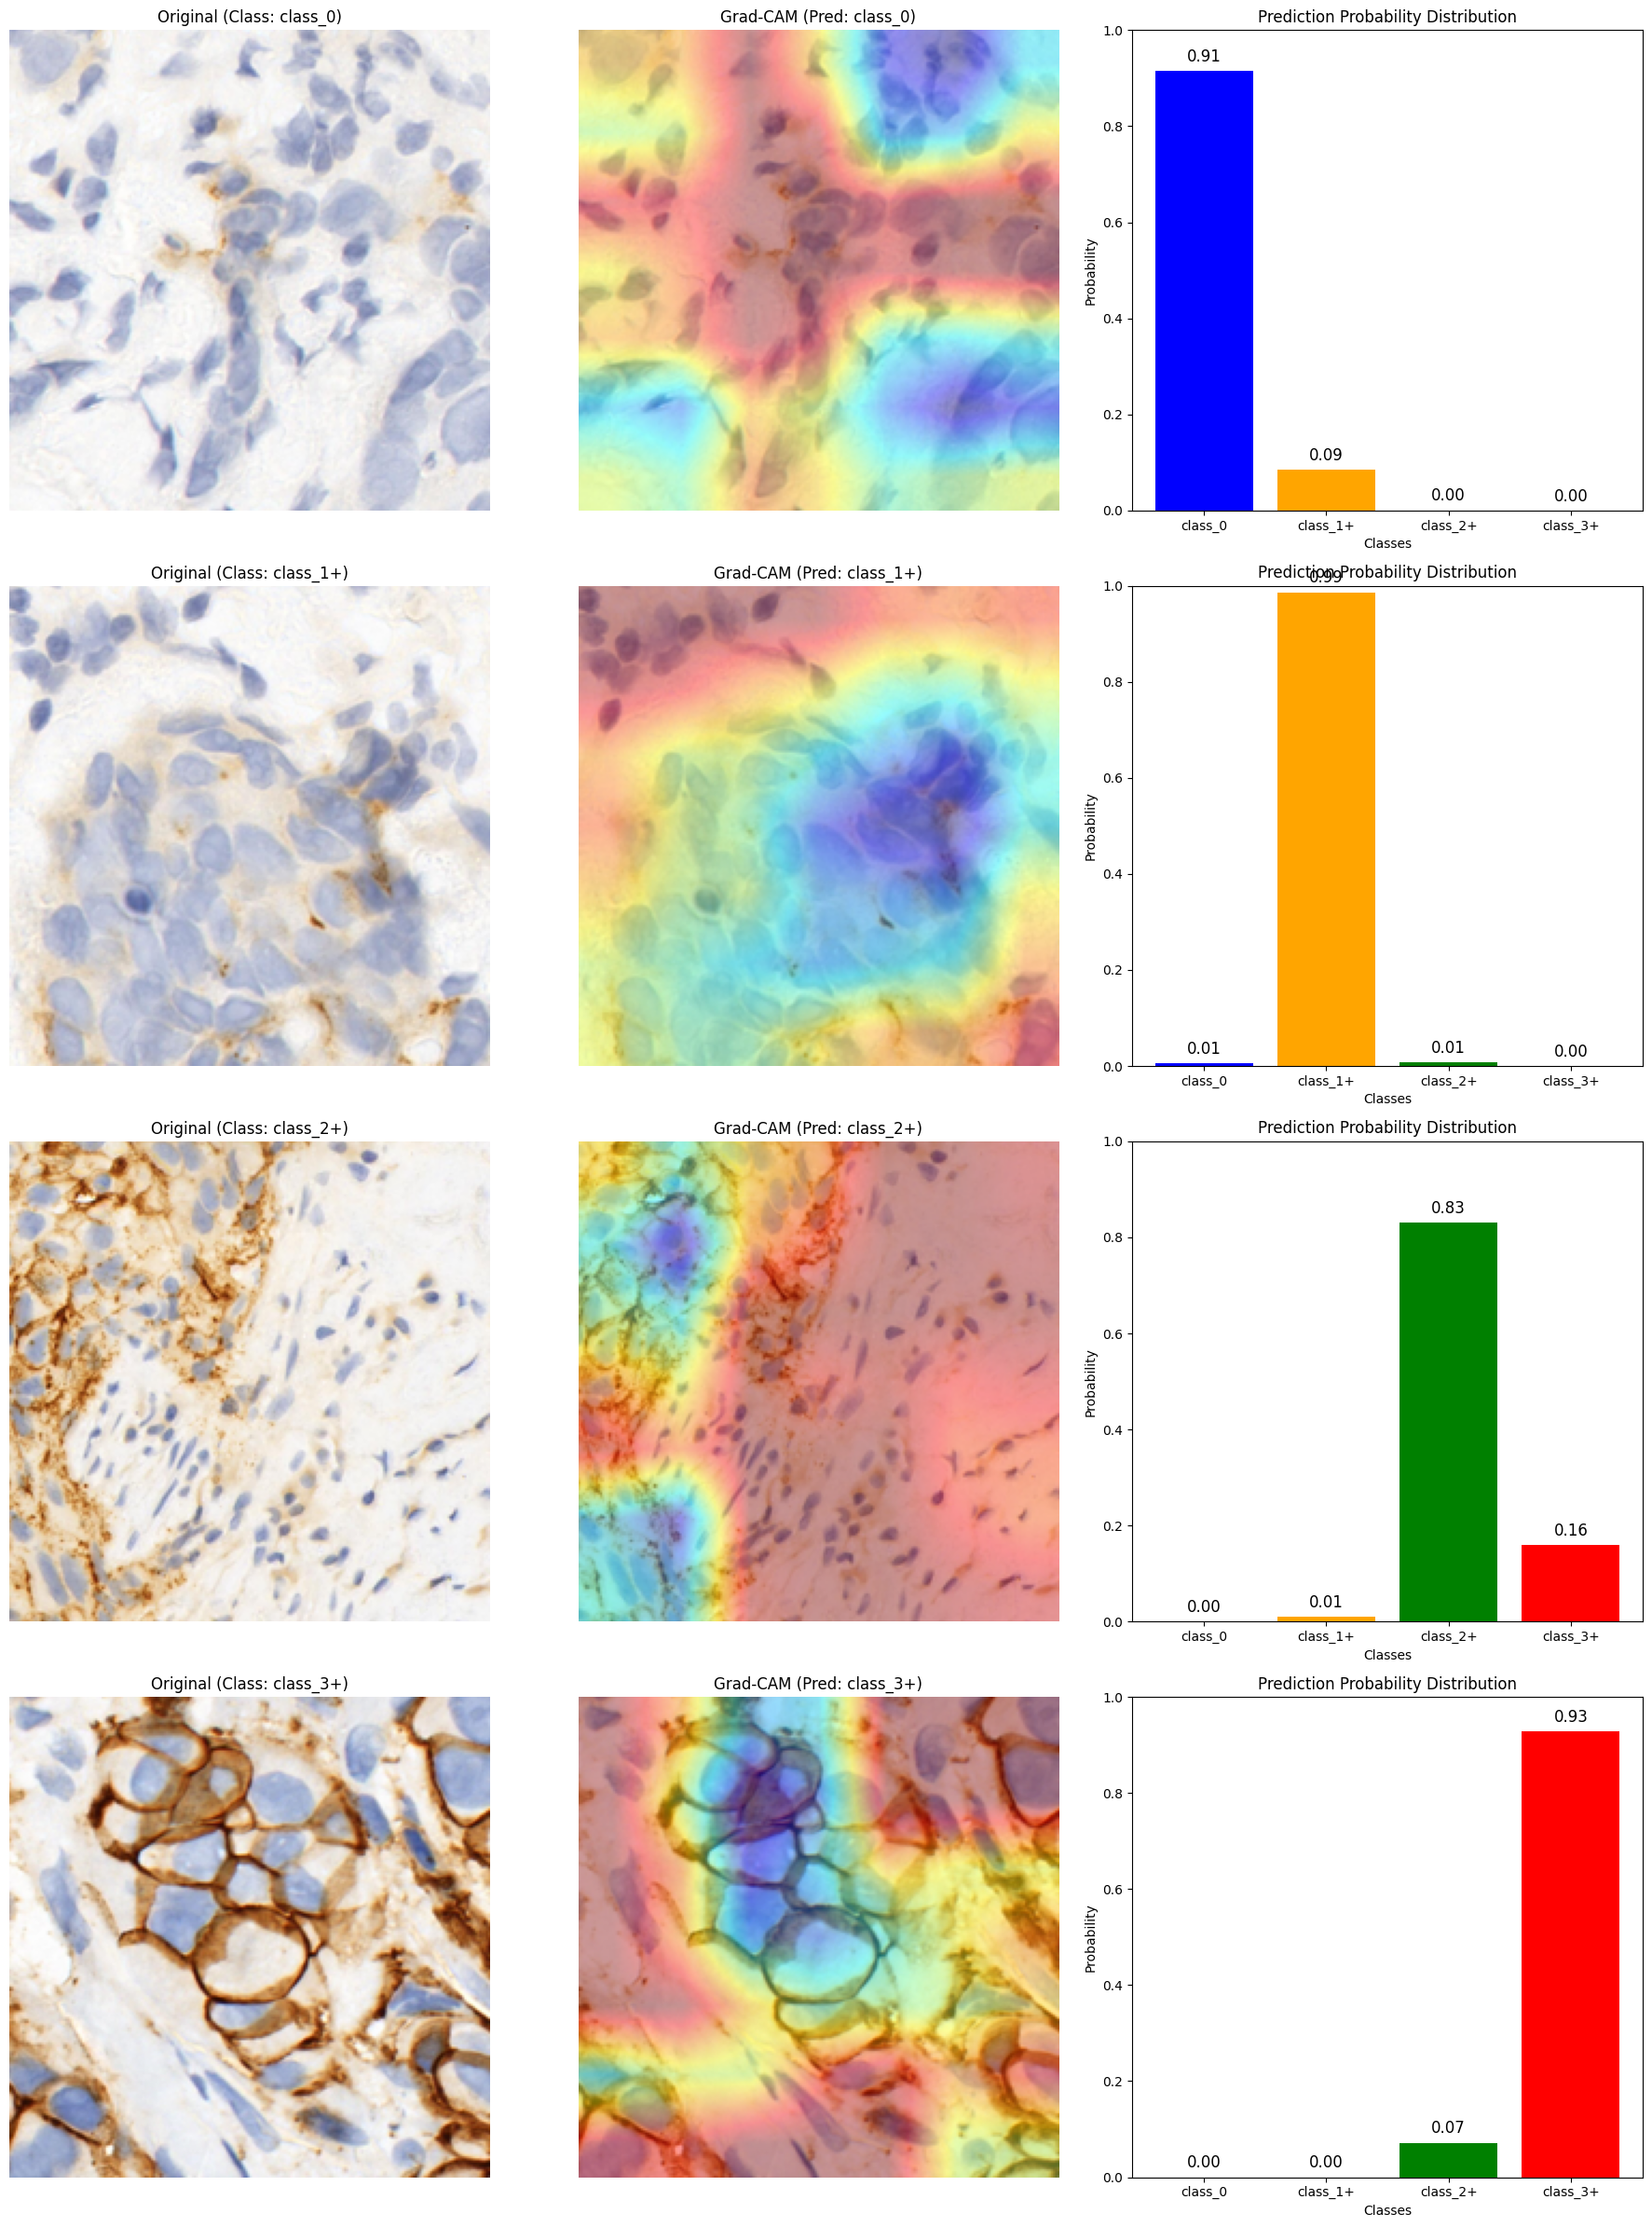

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import cv2
from PIL import Image
import os

# Define class labels
custom_class_labels = ["class_0", "class_1+", "class_2+", "class_3+"]

# Function to compute Grad-CAM heatmap
def get_grad_cam(model, img_array, last_conv_layer_name="conv5_block16_concat"):
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predicted_class = np.argmax(predictions[0])
        class_channel = predictions[:, predicted_class]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)[0]
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy(), predicted_class, predictions.numpy()[0]

# Function to visualize multiple Grad-CAMs and probability distributions
def visualize_multiple_gradcams(image_paths, model):
    num_images = len(image_paths)
    fig, axes = plt.subplots(nrows=num_images, ncols=3, figsize=(18, 6 * num_images))

    for i, img_path in enumerate(image_paths):
        img = Image.open(img_path).convert("RGB")
        img = img.resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Extract class name from path
        true_class = os.path.basename(os.path.dirname(img_path))

        # Get Grad-CAM heatmap and prediction probabilities
        heatmap, predicted_class, probabilities = get_grad_cam(model, img_array)

        # Resize and apply heatmap
        heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Superimpose heatmap on original image
        img_rgb = np.array(img)
        superimposed_img = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

        # Display original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original (Class: {true_class})")
        axes[i, 0].axis("off")

        # Display Grad-CAM
        axes[i, 1].imshow(superimposed_img)
        axes[i, 1].set_title(f"Grad-CAM (Pred: {custom_class_labels[predicted_class]})")
        axes[i, 1].axis("off")

        # Plot prediction probabilities as a bar chart
        axes[i, 2].bar(custom_class_labels, probabilities, color=["blue", "orange", "green", "red"])
        axes[i, 2].set_ylim([0, 1])
        axes[i, 2].set_title("Prediction Probability Distribution")
        axes[i, 2].set_ylabel("Probability")
        axes[i, 2].set_xlabel("Classes")

        # Annotate each bar with the probability value
        for j, prob in enumerate(probabilities):
            axes[i, 2].text(j, prob + 0.02, f"{prob:.2f}", ha="center", fontsize=12)

    plt.tight_layout()
    plt.show()

# Example usage: Visualize multiple Grad-CAM images with probability graphs
sample_image_paths = [
    "/kaggle/input/new-dataset-her2/test/class_0/her2-0-score_test_1180.png",
    "/kaggle/input/new-dataset-her2/test/class_1+/her2-0-score_test_1299.png",
    "/kaggle/input/new-dataset-her2/test/class_2+/her2-1+-score_test_18.png",
    "/kaggle/input/new-dataset-her2/test/class_3+/her2-2+-score_test_178.png"
]

visualize_multiple_gradcams(sample_image_paths, model)


## Result Interpretation

The colored areas on the Grad-CAM image represent the importance of different regions in the image, based on the model’s decision for a given class. These colors, such as red, yellow, blue, and purple, correspond to the "intensity" of the contribution of each region of the image to the model's prediction.

Here's how to interpret the colors in the heatmap:

## Grad-CAM Color Mapping:
### Red/Orange: 
The areas with the most intense positive influence on the model’s prediction for the predicted class. The model is heavily relying on these regions to make its classification decision.
### Yellow/Green: 
Areas with moderate importance in predicting the class, contributing to the decision but not as strongly as the red/orange areas.
### Blue/Purple: 
The regions with the least contribution or negative influence in the decision-making process. These areas are not important in the model’s classification for the given class.

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


69/69 ━━━━━━━━━━━━━━━━━━━━ 51s 572ms/step


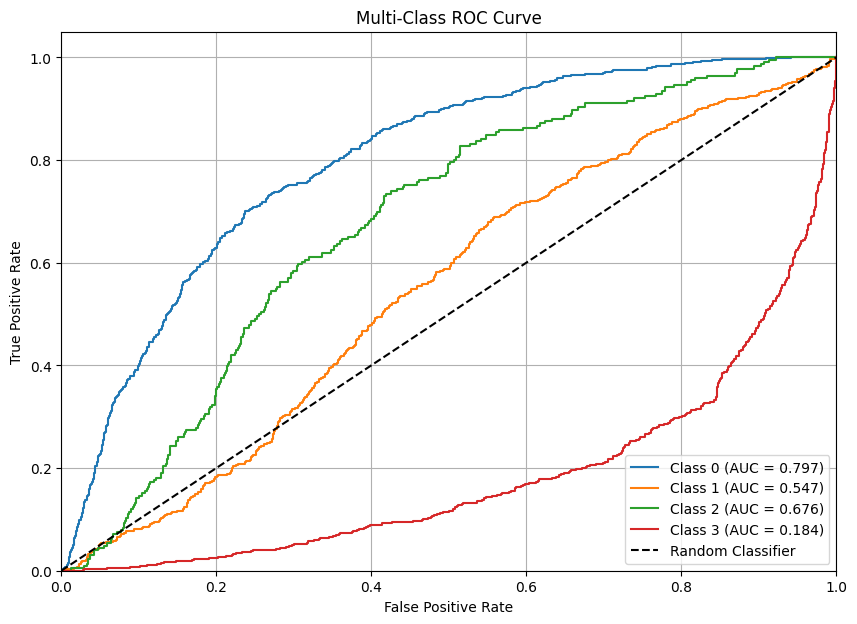


AUC-ROC Scores:
Class 0: 0.7969
Class 1: 0.5467
Class 2: 0.6763
Class 3: 0.1836


In [9]:
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Get the true labels from test_generator
y_true = test_generator.classes  # Extract true labels from generator
y_true_one_hot = label_binarize(y_true, classes=[0, 1, 2, 3])  # Convert to one-hot encoding

# Get predicted probabilities
y_probs = model.predict(test_generator)  # Softmax probabilities for each class

# Compute AUC-ROC for each class
n_classes = len(test_generator.class_indices)  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 7))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

# Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Print AUC-ROC scores for each class
print("\nAUC-ROC Scores:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.4f}")


In [10]:
# Compute macro-average AUC (simple mean)
macro_auc = np.mean(list(roc_auc.values()))

# Compute weighted-average AUC (accounts for class imbalance)
class_counts = np.bincount(y_true)  # Get number of samples per class
weights = class_counts / np.sum(class_counts)  # Normalize class distribution
weighted_auc = np.sum([roc_auc[i] * weights[i] for i in range(n_classes)])

print(f"Macro AUC: {macro_auc:.4f}")
print(f"Weighted AUC: {weighted_auc:.4f}")


Macro AUC: 0.5509
Weighted AUC: 0.5343


In [11]:
from sklearn.metrics import confusion_matrix, classification_report

# Get predicted labels
y_pred_labels = np.argmax(y_probs, axis=1)  # Convert probabilities to class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report (Precision, Recall, F1-score)
class_report = classification_report(y_true, y_pred_labels, target_names=custom_class_labels)
print("\nClassification Report:\n", class_report)


Confusion Matrix:
 [[134  49  72 503]
 [ 28 157 131 222]
 [  4  92 104  26]
 [ 46 222 351  59]]

Classification Report:
               precision    recall  f1-score   support

     class_0       0.63      0.18      0.28       758
    class_1+       0.30      0.29      0.30       538
    class_2+       0.16      0.46      0.24       226
    class_3+       0.07      0.09      0.08       678

    accuracy                           0.21      2200
   macro avg       0.29      0.25      0.22      2200
weighted avg       0.33      0.21      0.22      2200



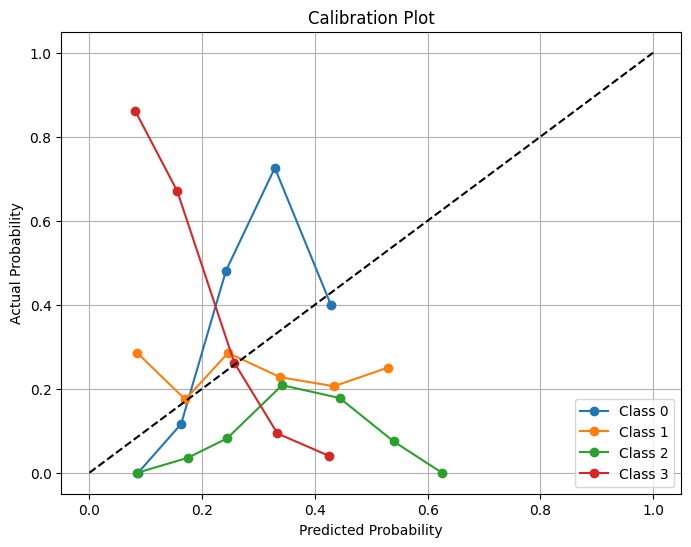

In [12]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    prob_true, prob_pred = calibration_curve(y_true_one_hot[:, i], y_probs[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {i}')

plt.plot([0, 1], [0, 1], "k--")  # Perfect calibration line
plt.xlabel("Predicted Probability")
plt.ylabel("Actual Probability")
plt.title("Calibration Plot")
plt.legend()
plt.grid()
plt.show()


In [13]:
misclassified_indices = np.where(y_pred_labels != y_true)[0]

print("Misclassified Images:")
for idx in misclassified_indices[:5]:  # Show first 5 misclassified images
    print(f"True: {custom_class_labels[y_true[idx]]}, Predicted: {custom_class_labels[y_pred_labels[idx]]}")


Misclassified Images:
True: class_0, Predicted: class_1+
True: class_0, Predicted: class_2+
True: class_0, Predicted: class_3+
True: class_0, Predicted: class_3+
True: class_0, Predicted: class_2+
